In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib
import numpy as np
from scipy.stats import logistic
import scipy.stats
from scipy.optimize import basinhopping
from scipy import interpolate
from scipy import stats
from IPython.display import clear_output, Javascript, Markdown
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import clear_output
import scipy.io
from numpy import cross, eye, dot
from scipy.linalg import expm, norm
from scipy.special import iv, erfc
import gc
import datetime
import time
import mat73
import random
import matplotlib
import _spin_params as spin_pars
from _create_pdf import create_spins, create_spins_inhomo_g
from _helper_functions import normalize, tsallis, cauchy, find_nearest, odeintz, find_nearest_sorted_left, find_nearest_sorted, smooth_data
from _steady_state import a_steady, a_steady_with_sz
from _mbes import mbes, mbes_soc, mbes_no_cavity, mbes_soc_no_cavity, mbes_det
from _do_calculation import solve_mbes, solve_mbes_general, solve_mbes_without_cavity, get_pulses_from_cavity_field, solve_mbes_wait, solve_mbes_only_decay
# matplotlib.pyplot.switch_backend('nbagg')
# %qtconsole

In [2]:
gcoll = spin_pars.gcoll
q = spin_pars.q
quali = spin_pars.quali
fr = spin_pars.fr
kappa = np.pi*fr/quali  # HWHM
delta = spin_pars.delta  # detuning cavity to spin central frequency ws-wc
deltac = spin_pars.deltac  # detuning drive to cavity wc-wp
gperp = spin_pars.gperp  # HWHM
gpar = spin_pars.gpar  # 0.001 #HWHM
gammaq = spin_pars.gammaq
nbins = spin_pars.nbins  # 701#5000#20
nbins = spin_pars.nbins
g_number = spin_pars.g_number  # how many bins for inhomogeneous coupling
#g0 = gcoll/sqrt(nspins)
print(kappa)

7.14012477319922


In [3]:
def pulse_rwa(t, args):
    wgrund = args[0]
    fcomps = args[1]
    pulse = 0
    for i in range(len(fcomps)):
        pulse = pulse+(fcomps[i])*np.sin((i+1)*wgrund*t)
    return pulse


def pulse_rwa_gauss(t, args):
    wgrund = args[0]
    fcomps = args[1]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    width = 2*tend/(nfcomps+5)
    t0 = 3*width/2
    pulse = 0
    for i in range(len(fcomps)):
        pulse += fcomps[i]*np.exp(-4*(t-t0)**2*np.log(2)/width**2)
        t0 += 0.5*width
    pulse *= logistic.cdf(t, loc=0.01, scale=.002) * \
        (1-logistic.cdf(t, loc=tend-0.01, scale=.002))
    pulse *= 0.46971947398573455
    return pulse


def pulse_rwa_gauss_const(t, args):
    wgrund = args[0]
    fcomps = args[1]
    maxampl = args[2]
    nfcomps = len(fcomps)
    tend = np.pi/wgrund

    #xint = np.linspace(0, tend, nfcomps)

    #spline = interpolate.BSpline(xint, fcomps, 2)
    spline = 0
    for i in range(len(fcomps)):
        spline += (fcomps[i])*np.sin((i+1)*wgrund*t)

    #spline = spline/nfcomps
    pulsei = 0
    pulseq = 0
    pulse = 0
    pulse = maxampl*logistic.cdf(t, loc=0.02, scale=0.004) * \
        (1-logistic.cdf(t, loc=tend-0.02, scale=0.004))

    pulsei = pulse*np.cos(spline)
    pulseq = pulse*np.sin(spline)

    return pulsei, pulseq

In [4]:
def g_inhomo_function(x, sigma):
    return np.exp(-x**2/sigma**2)


x_start = 5
x_stop = 20  # µm
x = np.linspace(x_start, x_stop, g_number)
sigma = 5
g_temp = g_inhomo_function(x, sigma)
g_list = g_temp/np.sum(g_temp)

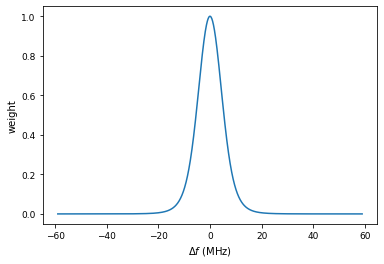

In [5]:
plt.close('all')
matplotlib.interactive(False)
spins, gs, pdf = create_spins_inhomo_g(
    gcoll, g_list, q, delta, gammaq, nbins, holes=False, inhomo=True, hyperfine=True)
plt.figure()
plt.plot(spins[:len(pdf)], pdf/max(pdf))
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('weight')
plt.show()

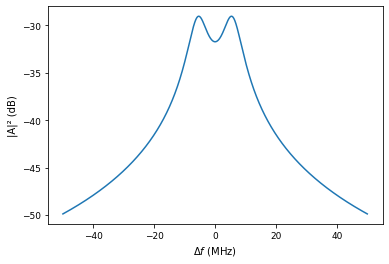

In [6]:
plt.close('all')
matplotlib.interactive(False)
initsteady = (0.1, 0.1)
fstart = 50
deltaarr = np.linspace(-fstart*2*np.pi, fstart*2*np.pi, 2000)
etasteady = 0.00001
losasteady = np.zeros(np.shape(deltaarr))
losareal = np.zeros(np.shape(deltaarr))
losaimag = np.zeros(np.shape(deltaarr))

newinit = initsteady
for i, delt in enumerate(deltaarr):
    ar, ai = a_steady(etasteady, delt, gs, spins, gpar, gperp, kappa, newinit)
    newinit = (ar, ai)
    losasteady[i] = ai**2+ar**2
    losareal[i] = ar
    losaimag[i] = ai

fig = plt.figure()
plt.xlabel('$\Delta f$ (MHz)')
plt.ylabel('|A|² (dB)')
plt.plot(deltaarr/2/np.pi, 10*np.log10(losasteady/0.0000000001))
#deltaarr[find(losasteady == max(losasteady))]/2/pi
plt.show()

# SOC pulses

In [7]:
pumptime = 100e-3  # 5*np.pi/gcoll

decaytime = 5000e-3
inittime = 800e-3
dt = 4e-3  # The time resolution of the AWG. Don't change that because the solution of the MBEs are written in a way that use that as time resolution
numsteps = int(pumptime/dt)
tpump = np.arange(0, pumptime+dt, dt)
tlistdecay = np.arange(0, decaytime+dt, dt)
tlistinit = np.arange(0, inittime+dt, dt)

In [16]:
alos = np.zeros(len(tlistdecay))
szlos = np.zeros(np.shape(alos))


initdec = np.ones(nbins*g_number*2+1)*(0.7)
initdec[0] = 0.001
initdec[1:nbins+1] = 0

detuning = 0  # MHz between spins and cavity

asolpump, asoldecay,  infodict = solve_mbes(
    mbes, initdec, pdf, tpump, tlistdecay,  0, kappa, deltac, gs, gperp, spins+detuning, gpar)


alos = np.hstack(
    (abs(asolpump[:, 0])**2, abs(asoldecay[:, 0])**2))
szlos = np.hstack((np.real(np.sum(
    asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
smlos = np.hstack((np.real(np.sum(
    asolpump[:, 1::2], axis=1)), np.real(np.sum(asoldecay[:, 1::2], axis=1))))

tplot = np.linspace(0, (decaytime), len(tlistdecay))
tplotall = np.arange(0, len(szlos)*dt, dt)

126.82464408617764


/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


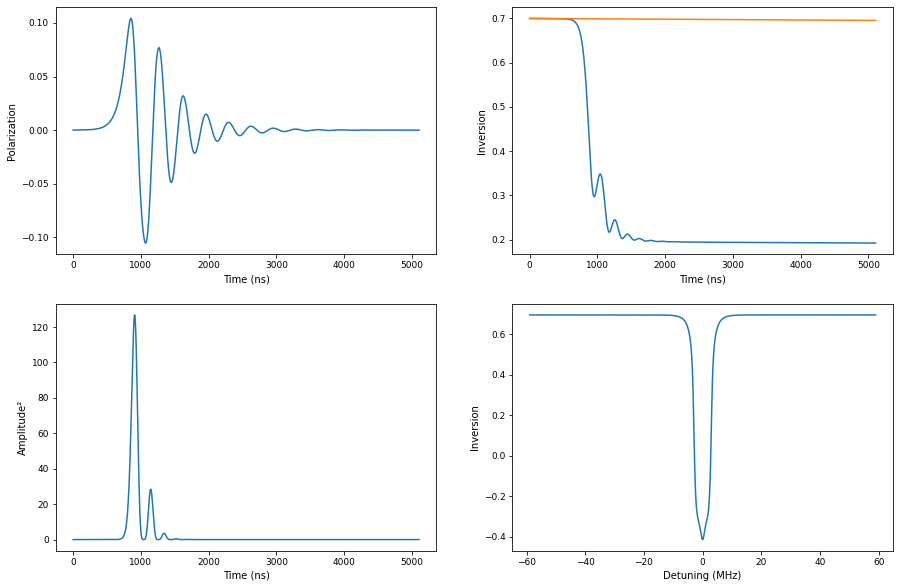

In [17]:
plt.close('all')
matplotlib.interactive(False)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(tplotall*1000, smlos)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Polarization')

ax2.plot(tplotall*1000, szlos)
ax2.plot(tplotall*1000, szlos[0]*(np.exp(-tplotall*gpar)*2-1))
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Inversion')


ax3.plot(tplotall*1000, np.abs(alos)**2)
print(max(np.abs(alos)**2))
ax3.set_xlabel('Time (ns)')
ax3.set_ylabel('Amplitude²')

ax4.plot(spins, asoldecay[-1, 2::2]/pdf)
ax4.set_xlabel("Detuning (MHz)")
ax4.set_ylabel("Inversion")
plt.show()

## starting offresonant and then switch detuning

In [12]:
init = np.ones(nbins*g_number*2+1, dtype=complex)*(0.8)
init[0] = -0.01*1j-0.02
init[1::2] = 0


timeswitch = 400e-3  # how long we are detuned
det_strength = -2*np.pi*10  # how far we are detuning the spins
timeafterswitch = 50000e-3  # time after we switch back
tswitch = np.arange(0, timeswitch, dt)

tall_switch = np.arange(0, timeswitch+timeafterswitch, dt)


dtswitch = 400e-3
tswi = np.arange(0, dtswitch, dt)
detoff = 1*2*np.pi


switch_off = np.flip(0.5*(1+np.tanh((tswi-dtswitch/2)/dtswitch*5)))+detoff
switch_off = normalize(switch_off, [detoff, 1+detoff], [detoff, det_strength])

delta_t_arr = np.ones(len(tall_switch))*det_strength

delta_t_arr[len(tswitch):(len(tswitch)+len(tswi))] = switch_off
delta_t_arr[(len(tswitch)+len(tswi)):] = detoff

solution_switch,  infodict = solve_mbes_general(
    mbes_det, init, pdf, tall_switch, delta_t_arr, tall_switch, kappa, deltac, gs, gperp, spins, gpar)
alos_switch = np.hstack(
    (abs(solution_switch[:, 0])**2))
szlos_switch = np.hstack((np.real(np.sum(
    solution_switch[:, 2::2], axis=1))))
smlos_switch = np.hstack((np.sum(
    solution_switch[:, 1::2], axis=1)))
sxlos_switch = np.real(smlos_switch)
sylos_switch = -np.imag(smlos_switch)

1238.4345859712375


/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


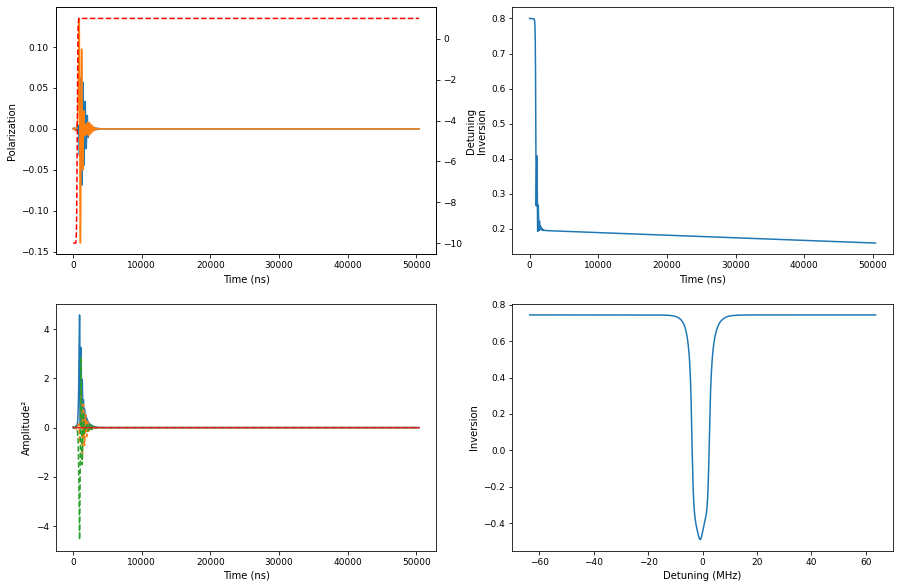

In [13]:
plt.close('all')
matplotlib.interactive(False)
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

ax1.plot(tall_switch*1000, sxlos_switch)
ax1.plot(tall_switch*1000, sylos_switch)
ax1.set_xlabel('Time (ns)')
ax1.set_ylabel('Polarization')

ax1twin = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax1twin.plot(tall_switch*1000, delta_t_arr/2/np.pi, 'r--')
ax1twin.set_ylabel('Detuning')  # we already handled the x-label with ax1


ax2.plot(tall_switch*1000, szlos_switch)
ax2.set_xlabel('Time (ns)')
ax2.set_ylabel('Inversion')


ax3.plot(tall_switch*1000, np.sqrt(alos_switch))
ax3.plot(tall_switch*1000, np.real(solution_switch[:, 0]), '--')
ax3.plot(tall_switch*1000, np.imag(solution_switch[:, 0]), '--')
ax3.plot(tall_switch*1000, np.imag(alos_switch))
print(max(np.abs(alos)**2))
ax3.set_xlabel('Time (ns)')
ax3.set_ylabel('Amplitude²')

ax4.plot(spins, solution_switch[-1, 2::2]/pdf)
ax4.set_xlabel("Detuning (MHz)")
ax4.set_ylabel("Inversion")
plt.show()

## simulate tipping angle vs. amplitude

In [427]:
def randdist(x, pdf, nvals):
    """Produce nvals random samples from pdf(x), assuming constant spacing in x."""

    # get cumulative distribution from 0 to 1
    cumpdf = np.cumsum(pdf)
    cumpdf *= 1/cumpdf[-1]

    # input random values
    randv = np.random.uniform(size=nvals)

    # find where random values would go
    idx1 = np.searchsorted(cumpdf, randv)
    # get previous value, avoiding division by zero below
    idx0 = np.where(idx1 == 0, 0, idx1-1)
    idx1[idx0 == 0] = 1

    # do linear interpolation in x
    frac1 = (randv - cumpdf[idx0]) / (cumpdf[idx1] - cumpdf[idx0])
    randdist = x[idx0]*(1-frac1) + x[idx1]*frac1

    return randdist


def fluctuations(x, b):
    s1 = np.exp(-x**2/b**2)
    s2 = np.sqrt(b)*np.pi
    return s1/s2

In [528]:
amplitudes = np.linspace(0, 5, 1)
number_of_iterations = 200
tipping_angles = np.zeros((len(amplitudes), number_of_iterations))
td = np.zeros((len(amplitudes), number_of_iterations))


coherent_angle = 22*np.pi/180
coherent_amplitude = 0.2*0
mean_random_tilt = 0.02
x = np.linspace(0, np.pi/2, 1000)
pdfvals = fluctuations(x, mean_random_tilt)

alosarr = []
for i, amp in enumerate(amplitudes):
    print("Doing amplitude %i of %i" % (i+1, len(amplitudes)))
    for j in range(number_of_iterations):
        print("Doing iteration %i of %i" %
              (j+1, number_of_iterations), end="\r")
        initdec = np.ones(2*nbins+1, dtype=complex)
        initdec[0] = 0

        random_angle = np.random.uniform(0, 2*np.pi)
        random_amplitude = randdist(x, pdfvals, 1)

        initsm = np.sin(random_amplitude)*np.exp(1j*random_angle)
        initsz = np.cos(random_amplitude)*0.5

        initdec[1::2] = initsm
        initdec[2::2] = initsz

        asolpump, asoldecay,  infodict = solve_mbes(
            mbes, initdec, pdf, tpump, tlistdecay,  amp+coherent_amplitude*np.exp(1j*coherent_angle), kappa, deltac, gs, gperp, spins, gpar)
        alos = np.hstack(
            (abs(asolpump[:, 0])**2, abs(asoldecay[:, 0])**2))
        szlos = np.hstack((np.real(np.sum(
            asolpump[:, 2::2], axis=1)), np.real(np.sum(asoldecay[:, 2::2], axis=1))))
        smlos = np.hstack((np.real(np.sum(
            asolpump[:, 1::2], axis=1)), np.real(np.sum(asoldecay[:, 1::2], axis=1))))

        smp = np.real(np.sum(
            asolpump[:, 1::2], axis=1))
        szp = np.real(np.sum(
            asolpump[:, 2::2], axis=1))
        tipping_angles[i, j] = np.arctan(smp[-1]/szp[-1])
        maxidx = np.where(alos == max(alos))[0][0]
        tall = np.arange(0, len(szlos)*dt, dt)
        td[i, j] = tall[maxidx]
        alosarr.append(alos)
    clear_output(wait=True)
alosarr = np.asarray(alosarr)

Doing amplitude 1 of 1


In [506]:
class tddist_rice(scipy.stats.rv_continuous):
    def _pdf(self, x, tr, t0, n0, eta):
        n = n0*1000
        jac = np.exp((t0-x)/(2*tr))
        thetae = 2*np.exp((t0-x)/(2*tr))
        s1 = np.exp(-n*(eta**2+thetae**2)/4)
        return jac*n/2*thetae*s1*iv(0, eta*thetae*n/2)

    def _argcheck(self, tr, t0, n0, eta):
        s1 = tr > 0.0
        s2 = -6. < t0 < 6.

        s3 = n0 > 0.0
        s4 = eta >= 0.0

        return s1 & s2 & s3 & s4


class phidist_rice(scipy.stats.rv_continuous):
    def _pdf(self, x, n0, eta):
        n = n0*1000
        mtilde = eta*np.cos(x)
        sigma = np.sqrt(2/n)
        q = 0.5*erfc(-mtilde/(np.sqrt(2)*sigma))
        s1 = 1/(2*np.pi)*np.exp(-eta**2/(2*sigma**2))
        s2 = mtilde/(2*np.pi*sigma)*q*np.exp((mtilde**2-eta**2)/(2*sigma**2))
        return s1+s2

    def _argcheck(self, n0, eta):
        s3 = n0 > 0.0
        s4 = eta >= 0.0

        return s3 & s4
# %qtconsole

In [510]:
tddist_inst = tddist_rice(name='tddist_rice')
phidist_inst = phidist_rice(name='phidist_rice')
res = tddist_inst.fit(td[0],  0.05, -0.125, 4, 0,
                      f0=0.1, f3=0, floc=0, fscale=1)

tfit = res[0]
t0fit = res[1]
nfit = res[2]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1871: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2639: RuntimeWarning: divide by zero encountered in double_scalars
  Shat = sqrt(mu2hat / mu2)


In [538]:
etavals = [0]
for k in td[1:]:
    res2 = tddist_inst.fit(k, tfit, t0fit, nfit, 0.1, f0=tfit, f1=t0fit,
                           f2=nfit, floc=0, fscale=1)
    etavals.append(res2[3])
etavals = np.asarray(etavals)

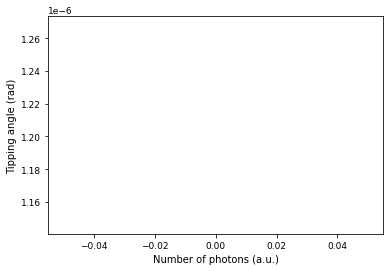

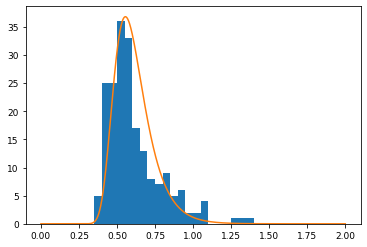

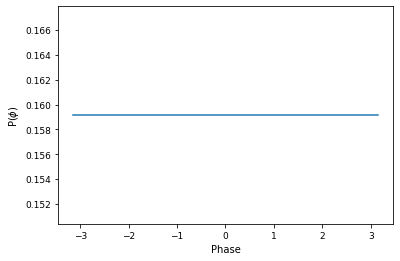

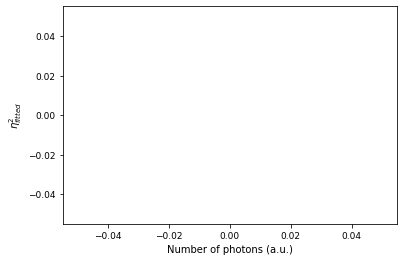

In [535]:
plt.close('all')
matplotlib.interactive(False)

tdplot = np.linspace(0, 2, 1000)
phis = np.linspace(-np.pi, np.pi, 1000)

plt.plot(amplitudes**2, np.mean(tipping_angles, axis=1)**2)
plt.xlabel("Number of photons (a.u.)")
plt.ylabel("Tipping angle (rad)")

bin_size = 0.05
min_edge = 0
max_edge = tdplot[-1]
N = (max_edge-min_edge)/bin_size
bin_list = np.linspace(min_edge, max_edge, int(N+1))

idx = 0
plt.figure()
plt.hist(td[idx], bin_list)
plt.plot(tdplot, 100*tddist_inst._pdf(tdplot, tfit, t0fit, nfit, etavals[idx]))

plt.figure()
plt.xlabel("Phase")
plt.ylabel("P($\phi$)")
plt.plot(phis, phidist_inst._pdf(phis, nfit, etavals[idx]))

plt.figure()
plt.plot(amplitudes**2, etavals**2)
plt.xlabel("Number of photons (a.u.)")
plt.ylabel("$\eta^2_{fitted}$")
plt.show()

In [159]:
data = scipy.io.loadmat(
    "/home/andreas/Physics/data_fit_detector_scans_ALL_20220525_1.mat", simplify_cells=True)

In [160]:
tddata = data['tmx']
powdata = data['x_pow']

In [403]:
tddist_inst2 = tddist_rice(name='tddist_rice')
n0fix = 1e6
t0fix = -4.45
resdata = tddist_inst2.fit(
    tddata[0],  0.01, t0fix, n0fix, 0, f1=t0fix, f2=n0fix, f3=0, floc=0, fscale=1)
tfitdata = resdata[0]
t0fitdata = resdata[1]
nfitdata = resdata[2]

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1871: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2639: RuntimeWarning: divide by zero encountered in double_scalars
  Shat = sqrt(mu2hat / mu2)
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1867: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


In [472]:
etafitted = [0]

val = 0
for k in tddata[1:]:
    res2data = tddist_inst2.fit(k,  tfitdata, t0fitdata, nfitdata, val, f0=tfitdata, f1=t0fitdata,
                                f2=nfitdata, floc=0, fscale=1)
    etafitted.append(res2data[3])
    val = resdata[3]
etafitted = np.asarray(etafitted)

/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:1871: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  return integrate.quad(self._pdf, _a, x, args=args)[0]
/usr/local/lib/python3.10/dist-packages/scipy/stats/_distn_infrastructure.py:2639: RuntimeWarning: divide by zero encountered in double_scalars
  Shat = sqrt(mu2hat / mu2)


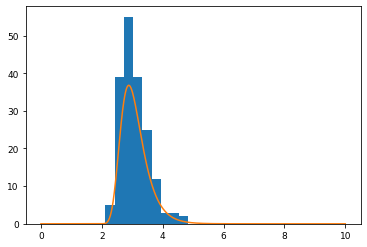

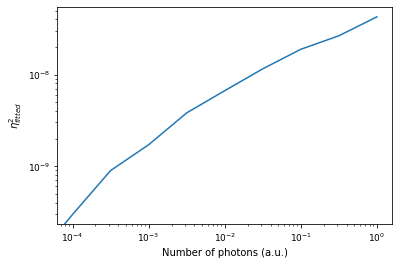

In [473]:
plt.close('all')
matplotlib.interactive(False)
tdplotdata = np.linspace(0, 10, 1000)
idx = 0

bin_size = 0.3
min_edge = 0
max_edge = tdplotdata[-1]
N = (max_edge-min_edge)/bin_size
bin_list = np.linspace(min_edge, max_edge, int(N+1))


plt.hist(tddata[idx], bin_list)
plt.plot(tdplotdata, 100*tddist_inst2._pdf(tdplotdata,
         tfitdata, t0fitdata, nfitdata, etafitted[idx]))
plt.figure()
plt.loglog(powdata, etafitted**2)
plt.xlabel("Number of photons (a.u.)")
plt.ylabel("$\eta^2_{fitted}$")
plt.show()